In [62]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

In [63]:
def wave2D(L=0.5, N=50, Dt=1e-4, Nt=100, step=1,
           rho=1.5e-3, tension=5., aspect=1):

    Lx = L
    Ly = aspect*L
    Nx = N
    Ny = int(aspect*N)
    delta = L/N

    c = np.sqrt(tension/rho)

    beta = c*Dt/delta
    beta2 = beta**2

    print("c = {0} m/s".format(c))
    print("delta = {0} m,  Dt = {1} s, delta/Dt = {2} m/s".format(delta, Dt, delta/Dt))
    print("beta = {}".format(beta))
    print("beta * sqrt(2) = {}".format(beta * np.sqrt(2)))


    x = np.linspace(0, Lx, Nx+1)  # need N+1!
    y = np.linspace(0, Ly, Ny+1)
    # note: we use u[i*delta, j*delta] = u(x, y)
    #       (which is the transpose of the numpy row-column layout so we transpose X and Y)
    X, Y = np.meshgrid(x, y)
    X, Y = X.T, Y.T

    def gaussian(x, u0=0.05, x0=None, sigma=0.1*L):
        x0 = np.mean(x) if x0 is None else x0
        g = u0/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-x0)**2 / (2*sigma**2))
        return g

    # u[i*delta, j*delta] = u(x, y)
    # displacements at j-1, j, j+1
    u0 = np.zeros((Nx+1, Ny+1))
    u1 = np.zeros_like(u0)
    u2 = np.zeros_like(u0)

    # save array
    u_t = np.zeros((int(np.ceil(Nt/step)), Nx+1, Ny+1))

    # use a boolean mask to define regions
    inside = np.zeros_like(u0, dtype=np.bool)
    inside[1:-1, 1:-1] = True
    boundary = np.logical_not(inside)

    # boundary conditions
    def set_boundary_conditions(u):
        u[boundary] = 0

    set_boundary_conditions(u0)
    set_boundary_conditions(u1)
    set_boundary_conditions(u2)

    x0_1 = L / 3  # Center of the first drop
    x0_2 = 2 * L / 3  # Center of the second drop
    # initial conditions: velocity 0, i.e. no difference between y0 and y1
    u0[inside] = u1[inside] =  (gaussian(X, u0=0.05, x0=x0_1)*gaussian(Y, u0=0.05, x0=x0_1) + gaussian(X, u0=0.05, x0=x0_2)*gaussian(Y, u0=0.05, x0=x0_2))[inside]
    # save initial
    t_index = 0
    u_t[t_index, :, :] = u0
    if step == 1:
        t_index += 1
        u_t[t_index, :, :] = u1

    for nt in range(2, Nt):
        u2[1:-1, 1:-1] = 2*(1-2*beta2)*u1[1:-1, 1:-1] - u0[1:-1, 1:-1] + beta2*(u1[2:, 1:-1]
                                            + u1[:-2, 1:-1] + u1[1:-1, 2:] + u1[1:-1, :-2])
        u0[:, :], u1[:, :] = u1, u2

        if nt % step == 0 or nt == Nt-1:
            t_index += 1
            u_t[t_index, :, :] = u2
            print("Iteration {0:5d}".format(nt), end="\r")
    else:
        print("Completed {0:5d} iterations: t={1} s".format(nt, nt*Dt))

    return u_t, X, Y, delta, Dt, step


In [64]:
u_t, X, Y, delta, Dt, step = wave2D(Nt=1000)

c = 57.735026918962575 m/s
delta = 0.01 m,  Dt = 0.0001 s, delta/Dt = 100.0 m/s
beta = 0.5773502691896257
beta * sqrt(2) = 0.816496580927726
Completed   999 iterations: t=0.0999 s


C:\Users\R Yan\AppData\Local\Temp\ipykernel_17580\3516254984.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inside = np.zeros_like(u0, dtype=np.bool)


In [65]:
times = Dt * np.arange(0, len(u_t))

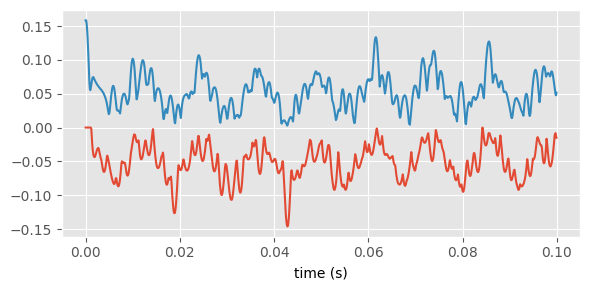

In [66]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.plot(times, u_t.min(axis=(1, 2)),
         times, u_t.max(axis=(1, 2)))
ax.set_xlabel("time (s)")
fig.tight_layout()
plt.show()

In [67]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

In [68]:
def plot_wireframe(X, Y, u, limits=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(X, Y, u)
    ax.set_xlabel(r"position $x$ (m)")
    ax.set_ylabel(r"position $y$ (m)")
    ax.set_zlabel(r"displacement $u$ (m)")
    ax.set_zlim(limits)
    ax.figure.tight_layout()
    return ax

<Axes3D: xlabel='position $x$ (m)', ylabel='position $y$ (m)', zlabel='displacement $u$ (m)'>

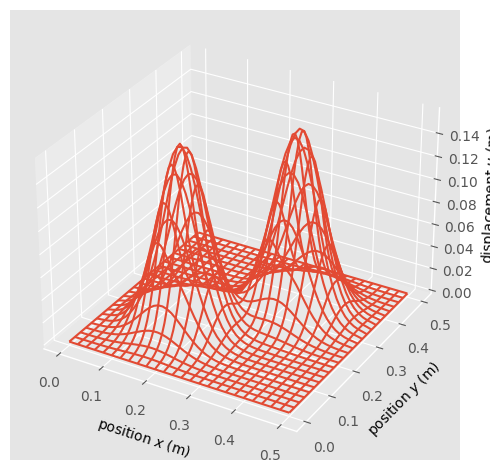

In [69]:
plot_wireframe(X, Y, u_t[0])

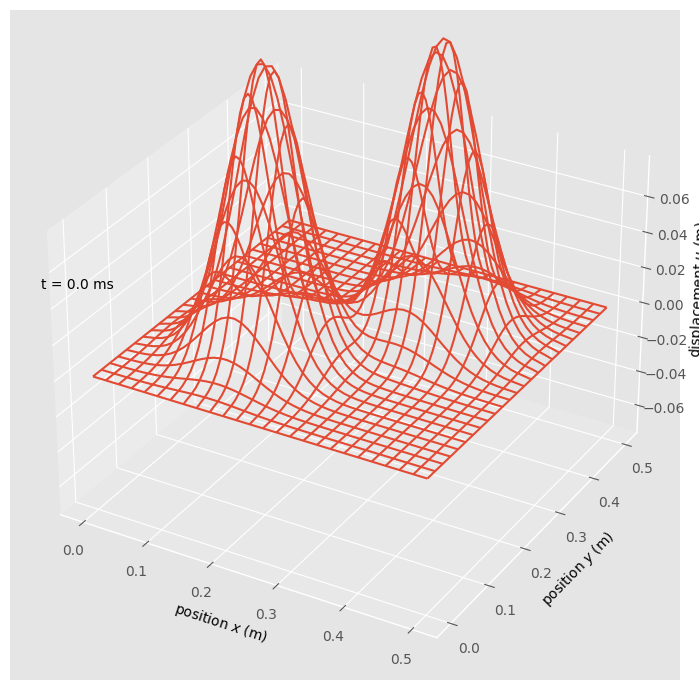

In [70]:
u_limits = 0.5*u_t.min(), 0.5*u_t.max()

fig2 = plt.figure(figsize=(7,7))
ax = fig2.add_subplot(111, projection="3d")
#ax.set_aspect(1)

def update_wire(frame, data):
    global ax, u_limits, X, Y
    ax.clear()
    plot_wireframe(X, Y, data[frame], limits=u_limits, ax=ax)
    ax.text(0.1, 0.9, 0.9, "t = {0:3.1f} ms".format(frame*Dt*1000), transform=ax.transAxes)

wire_anim = animation.FuncAnimation(fig2, update_wire, len(u_t), fargs=(u_t,),
                                    interval=30, blit=False, repeat_delay=1000)

In [71]:
wire_anim.save("square_drum_wire.tif", fps=30, dpi=300)

MovieWriter ffmpeg unavailable; using Pillow instead.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\Anaconda\envs\pytorch\lib\site-packages\matplotlib\animation.py", line 231, in saving
    yield self
  File "D:\Anaconda\envs\pytorch\lib\site-packages\matplotlib\animation.py", line 1099, in save
    writer.grab_frame(**savefig_kwargs)
  File "D:\Anaconda\envs\pytorch\lib\site-packages\matplotlib\animation.py", line 491, in grab_frame
    self.fig.savefig(
  File "D:\Anaconda\envs\pytorch\lib\site-packages\matplotlib\figure.py", line 3328, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "D:\Anaconda\envs\pytorch\lib\site-packages\matplotlib\backend_bases.py", line 2362, in print_figure
    result = print_method(
  File "D:\Anaconda\envs\pytorch\lib\site-packages\matplotlib\backend_bases.py", line 2228, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
  File "D:\Anaconda\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py", line 445, in print_raw
    FigureCanvasAgg.draw(self)
